# Diffusion probabilistic models - Score matching

#### Author : Philippe Esling (esling@ircam.fr)

This notebook explores the new class of generative models based on _diffusion probabilistic models_ [ [ 1 ] ](#ref1). This class of models is inspired by considerations from thermodynamics [ [ 2 ] ](#ref2), but also bears strong ressemblence to _denoising score matching_ [ [ 3 ] ](#ref3), _Langevin dynamics_ and _autoregressive decoding_. We will also discuss the more recent development of _denoising diffusion implicit models_ [ [ 4 ] ](#ref4), which bypass the need for a Markov chain to accelerate the sampling. Stemming from this work, we will also discuss the _wavegrad_ model [ [ 5 ] ](#ref5), which is based on the same core principles but applies this class of models for audio data. 

In order to fully understand the inner workings of diffusion model, we will review all of the correlated topics. Therefore, we split the explanation between four detailed notebooks.
   1. Score matching and Langevin dynamics.
   2. Diffusion probabilistic models and denoising
   3. Applications to waveforms with WaveGrad
   4. Implicit models to accelerate inference

## Score matching

In this section we start by reviewing all the foundations on **score matching** that can lead to fully understand diffusion models. To do so, we will work on the traditional _swiss roll_ dataset.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


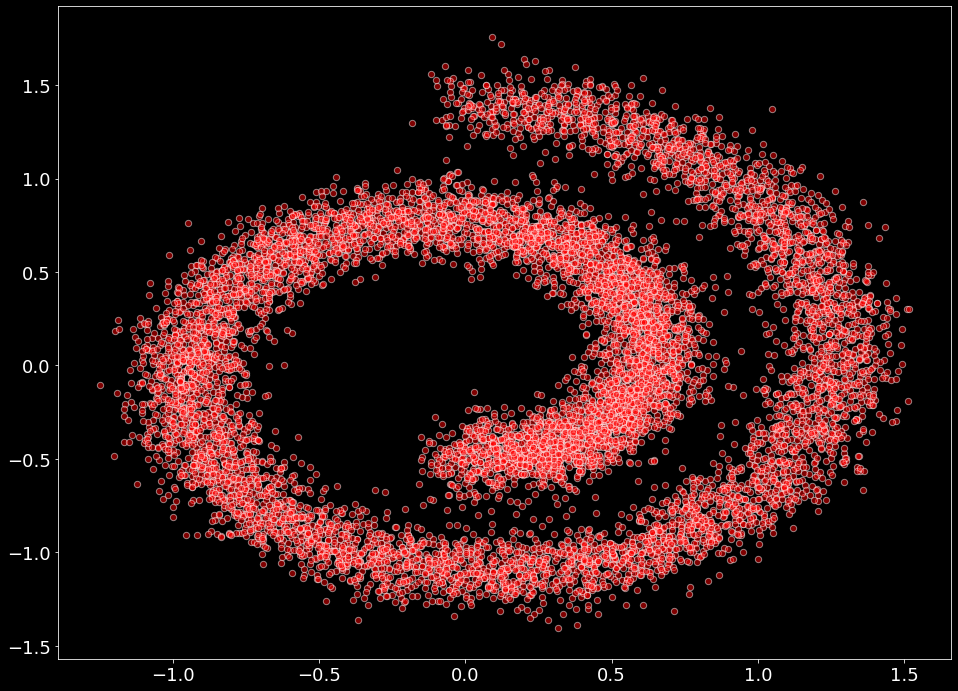

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
hdr_plot_style()
# Sample a batch from the swiss roll
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# Plot it
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

The idea of _score matching_ was originally proposed by Hyvarinen et al. [ [ 6 ] ](#ref6). Instead of learning directly the probability of the data $\log p(\mathbf{x})$, we rather aim to learn the _gradients_ of $\log p(\mathbf{x})$ with respect to $x$. In this case, the gradients $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ are termed the _score_ of the density $p(\mathbf{x})$, hence the name _score matching_. This can be understood as learning the _direction of highest probability_ at each point in the input space. Therefore, when the model is trained, we can improve a sample $x$ by moving it along the directions of highest probability. 

However, to perform training, we would need to minimize the error of our model $\mathcal{F}_{\theta}(\mathbf{x})$ at predicting the gradient $\nabla_{\mathbf{x}} \log p(\mathbf{x})$, which amounts to minimize the Fisher divergence, or simply the MSE

$$ \mathcal{L}_{mse} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\lVert \mathcal{F}_{\theta}(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \right\lVert_2^2 \right] $$

The real $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ is usually unknown, but under regularity assumptions on $p(\mathbf{x})$, it can be shown that the minimum of $\mathcal{L}_{mse}$ can be found through a tractable objective

$$ \mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

where $\nabla_{\mathbf{x}} \mathcal{F}_{\theta}(\mathbf{x})$ denotes the Jacobian of $\mathcal{F}_{\theta}(\mathbf{x})$ with respect to $\mathbf{x}$, and $ \text{tr}(\cdot) $ is the _trace_ operation.

To perform this optimization, we will rely on `Pytorch` and define $\mathcal{F}_{\theta}(\mathbf{x})$ as being a neural network

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Next, we need to define the loss function for the _score matching_ objective. First to compute the Jacobian, we need a specific (and differentiable) function. (This efficient implementation is based on a discussion that can be found [here](https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa))

In [4]:
import torch.autograd as autograd

def jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian

The actual _score matching_ loss function is split between the norm of the model output $\frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2$, which we compute first. Then, we compute the trace of the Jacobian loss $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \right)$ and return the sum as the full loss. 

In [5]:
def score_matching(model, samples, train=False):
    samples.requires_grad_(True)
    logp = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(logp, dim=-1) ** 2 / 2.
    # Compute the Jacobian loss
    jacob_mat = jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

Finally, we can run our code to train the model

In [7]:
dataset = torch.tensor(data.T).float()
for t in range(2000):
    print(t)
    # Compute the loss.
    loss = score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((t % 500) == 0):
        print(loss)

0
tensor(-2.3313, grad_fn=<MeanBackward1>)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
2

1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


We can observe that our model has learned to represent $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$ by plotting the output value across the input space

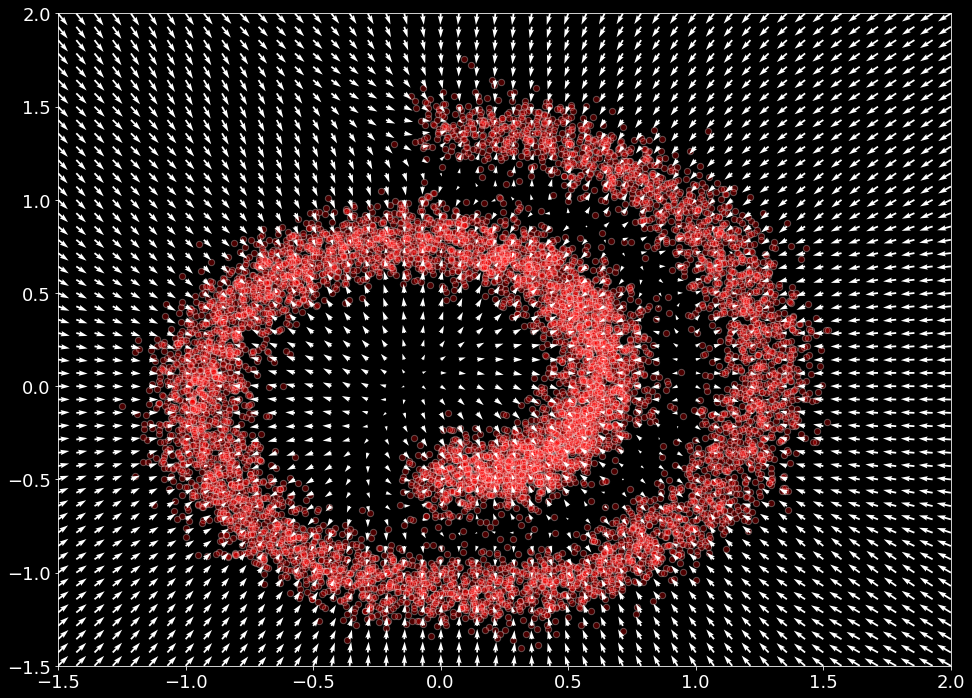

In [8]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.tensor(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, data)

### Langevin dynamics

After training, our model is able to produce an approximation of the gradient of the probabiliity, such that $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$. Therefore, we could use this to generate data by relying on a simple gradient ascent from a given point by using an initial sample $\mathbf{x}_{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$, and then using the gradient information to find a local maximum of $p(\mathbf{x})$

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \epsilon \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t)$$

where $\epsilon$ defines the size of the step we take in the direction of the gradient (akin to the _learning rate_).

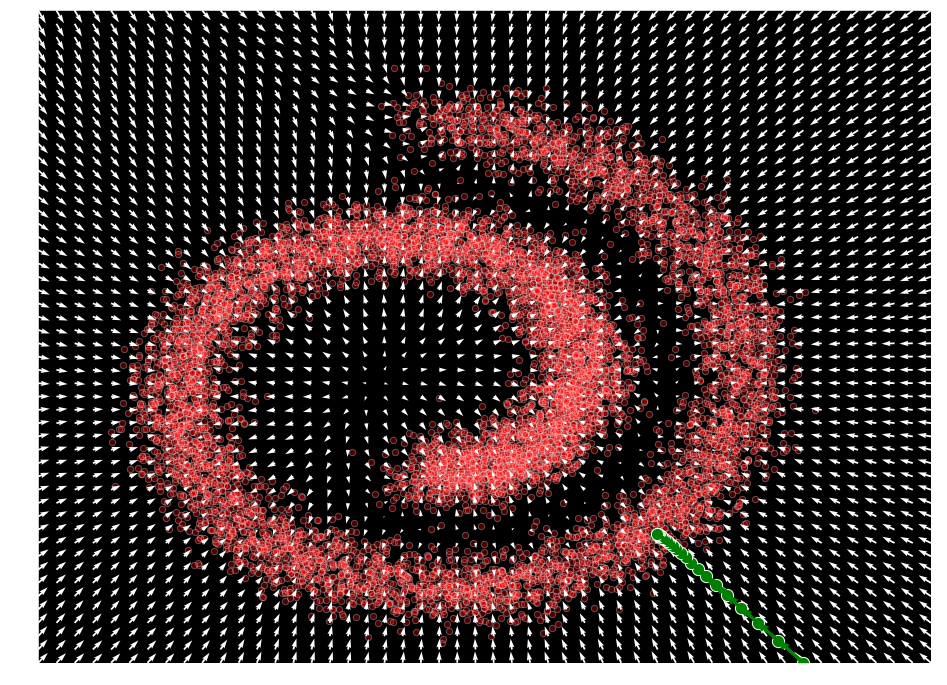

In [7]:
def sample_simple(model, x, n_steps=20, eps=1e-3):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        x = x + eps * model(x)
        x_sequence.append(x.unsqueeze(0))
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_simple(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each  step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

However, the previous procedure does not produce a true sample from $\mathbf{x} \sim p(\mathbf{x})$. In order to obtain such a sample, we can rely on a special case of _Langevin dynamics_. In this case, _Langevin dynamics_ can produce true samples from the density $p(\mathbf{x})$, by relying only on $\nabla_{\mathbf{x}} \log p(\mathbf{x})$. The sampling is defined in a way very similar to MCMC approaches, by applying recursively

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t) + \sqrt{\epsilon} \mathbf{z}_{t}$$

where $\mathbf{z}_{t}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$. It has been shown in [Welling et al. (2011)](https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf) that under $\epsilon \rightarrow 0, t \rightarrow \inf$: $\mathbf{x}_t$ converges to an exact sample from $p(\mathbf{x})$. This is a key idea behind the _score-based generative modeling_ approach.

In order to implement this sampling procedure, we can once again start from $\mathbf{x}_{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$, and progressively anneal $\epsilon \rightarrow 0$ at each step, to obtain true samples from $p(\mathbf{x})$.

In [36]:
def sample_langevin(model, x, n_steps=10, eps=1e-2, decay=.9, temperature=1.0):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_langevin(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each mcmc step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

TypeError: forward() missing 1 required positional argument: 'y'

### Sliced score matching

The previously defined _score matching_ with this loss is not scalable to high-dimensional data, nor deep networks, because of the computation of $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right)$. Indeed, the computation of the Jacobian is a $O(N^2 + N)$ operation, thus not being suitable for high-dimensional problems, even with the optimized solution proposed in the previous code. More recently, Song et al. [ [ 7 ] ](#ref7) proposed to use random projections to approximate the computation of $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right)$ in score matching. This approach called _Sliced Score Matching_ allows to replace the optimization objective with

$$ E_{\mathbf{v} \sim \mathcal{N}(0, 1)} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \mathbf{v}^T \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \mathbf{v} + \frac{1}{2} \left\Vert \mathbf{v}^T \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

where $\mathbf{v} \sim \mathcal{N}(0, 1)$ are a set of Normal-distributed vectors. They show that this can be computed by using forward mode auto-differentiation, which is computationally efficient. This loss can be implemented as follows (where we compute once again the norm first, and then the Jacobian loss)

In [9]:
def sliced_score_matching(model, samples):
    samples.requires_grad_(True)
    # Construct random vectors
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    # Compute the optimized vector-product jacobian
    logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    # Compute the norm loss
    norm_loss = (logp * vectors) ** 2 / 2.
    # Compute the Jacobian loss
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)

As previously, we can perform a simple optimization of this loss given a set of examples.

In [10]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T)[:1000].float()
for t in range(2000):
    # Compute the loss.
    loss = sliced_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 500) == 0):
        print(loss)

tensor(0.1118, grad_fn=<MeanBackward1>)
tensor(-1.0128, grad_fn=<MeanBackward1>)
tensor(-5.7355, grad_fn=<MeanBackward1>)
tensor(-8.0160, grad_fn=<MeanBackward1>)


We can check our approximation by relying on the same function as before.

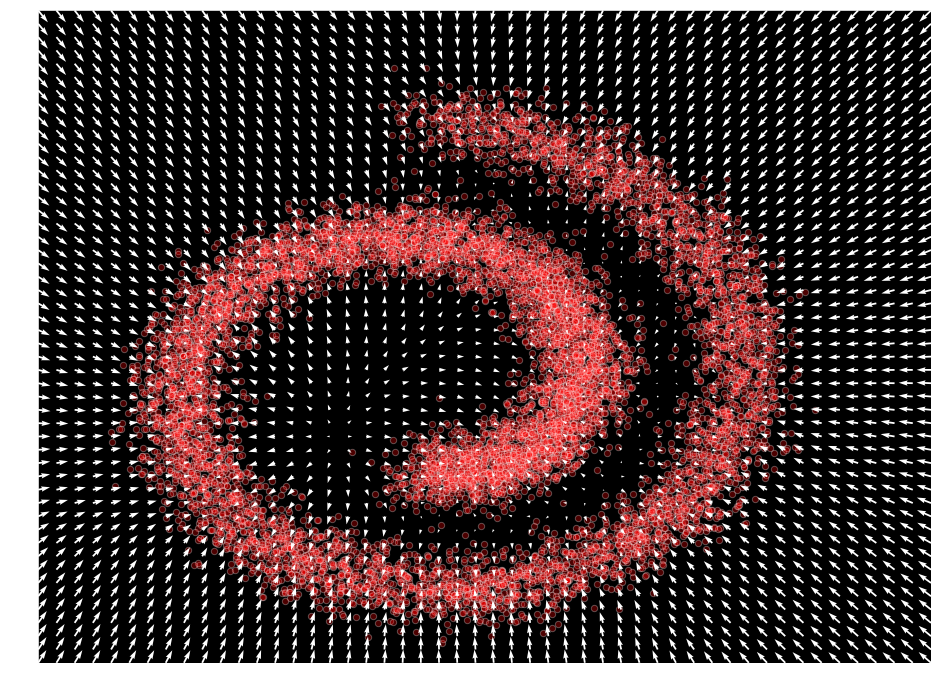

In [11]:
plot_gradients(model, data)

### Denoising score matching

Originally, the notion of _denoising score matching_ was discussed by Vincent [ [ 3 ] ](#ref3) in the context of _denoising auto-encoders_. In that case, this allows to completely remove the use of $\nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})$ in the computation of score matching. To do so, we can first corrupt the input point $\mathbf{x}$ with a given noise vector, leading to a distribution $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})$. Then, score matching can be used to estimate the score of this perturbed data distribution. It has been shown in [3], that the optimal network that approximates $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ can be found by minimizing the following objective

$$ E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) \right\lVert_2^2 \right]
, $$

However, it should be noted that $\mathcal{F}_{\theta}(\mathbf{x}) = \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ is only true when the noise is small enough to consider that $q_{\sigma}(\mathbf{x}) \approx p(\mathbf{x})$. As it has been shown in [ [ 3 ] ](#ref3),[ [ 8 ] ](#ref8), if we choose the noise distribution to be $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}\mid\mathbf{x}, \sigma^{2}\mathbf{I})$, then we have $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) = \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$. Therefore, the denoising score matching loss simply becomes

$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$

We can implement the _denoising score matching_ loss as follows

In [12]:
def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

We rely on the same model and optimizer as before

In [13]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
for t in range(5000):
    # Compute the loss.
    loss = denoising_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 1000) == 0):
        print(loss)

tensor(9778.1660, grad_fn=<MulBackward0>)
tensor(9862.8447, grad_fn=<MulBackward0>)
tensor(9976.3896, grad_fn=<MulBackward0>)
tensor(9933.9912, grad_fn=<MulBackward0>)
tensor(9779.1250, grad_fn=<MulBackward0>)


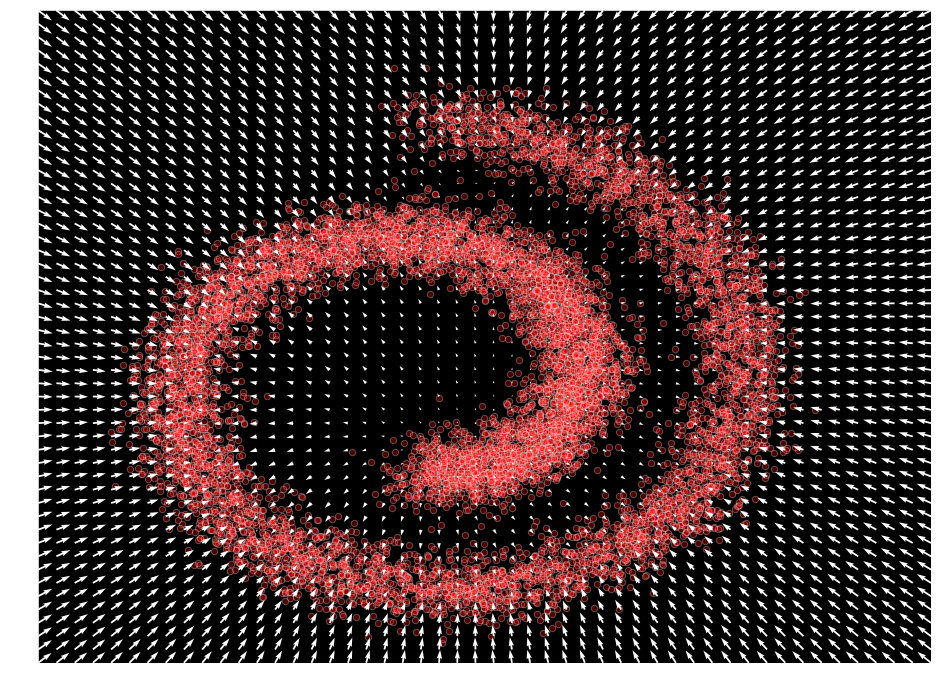

In [14]:
plot_gradients(model, data)

### Noise conditional score networks

In a recent paper, Song and Ermon [ [ 8 ] ](#ref8) built on these ideas to develop a score-based generative framework called _Noise-Conditional Score Networks_ (NCSN). They underlined several flaws in the existing score matching objectives. First, they showed that the use of (sliced) score matching without noise was inconsistent when the data followed the manifold hypothesis, ie. the noiseless objectives were only consistent when the distribution spanned the whole space. Second, they showed that low density regions could cause difficulties for both score matching and sampling with Langevin dynamics.

To address these issues, they propose to rely on perturbed data to bypass the manifold issues, but also to simultaneously estimate scores corresponding to all noise levels by training a single conditional score network. To do so, we consider a positive geometric sequence of noise variances $\{\sigma_{i}\}_{i=1}^{L}$, choosing $\sigma_{1}$ to be large enough to mitigate manifold issue, and satisfying $\frac{\sigma_{1}}{\sigma_{2}} = \cdots = \frac{\sigma_{L-1}}{\sigma_{L}} > 1$. The goal is to train a conditional network to estimate the gradients of all perturbed data distributions, ie.
$$
\forall \sigma \in \{\sigma_{i}\}_{i=1}^{L}, \mathcal{F}_{\theta}(\tilde{\mathbf{x}}, \sigma) \approx \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x})
$$
The network learning this is called a _Noise Conditional Score Network_ (NCSN). To perform this optimization, we start from the previously-defined denoising score matching objective
$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}, \sigma) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$
As this adress a single noise level, this objective can be combined to obtain a single unified objective as
$$
\mathcal{L}(\theta;\{\sigma_{i}\}_{i=1}^{L}) = \frac{1}{L} \sum_{i=1}^{L} \lambda(\sigma_{i})\mathcal{l}(\theta;\sigma_{i})
$$
where $\lambda(\sigma_{i}) > 0$ is a coefficient function depending on $\sigma_{i}$. This objective can be implemented as follows

In [15]:
def anneal_dsm_score_estimation(model, samples, labels, sigmas, anneal_power=2.):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
    scores = model(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power
    return loss.mean(dim=0)

As can be seen in the previous equation, this model requires a _conditional_ network $\mathcal{F}_{\theta}(\tilde{\mathbf{x}}, \sigma_{i})$ that also takes as input the different noise levels $\sigma_{i}$. Therefore, we redefine the previous model to account for that

In [16]:
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, num_classes):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(num_classes, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
    
class ConditionalModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lin1 = ConditionalLinear(2, 128, num_classes)
        self.lin2 = ConditionalLinear(128, 128, num_classes)
        self.lin3 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)

Finally, we can perform the same optimization as before

In [17]:
sigma_begin = 1
sigma_end = 0.01
num_classes = 4
sigmas = torch.tensor(np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))).float()
# Our approximation model
model = ConditionalModel(num_classes)
dataset = torch.tensor(data.T).float()
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for t in range(5000):
    # Compute the loss.
    labels = torch.randint(0, len(sigmas), (dataset.shape[0],))
    loss = anneal_dsm_score_estimation(model, dataset, labels, sigmas)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 1000) == 0):
        print(loss)

tensor(1.0319, grad_fn=<MeanBackward1>)
tensor(0.7983, grad_fn=<MeanBackward1>)
tensor(0.7847, grad_fn=<MeanBackward1>)
tensor(0.7673, grad_fn=<MeanBackward1>)
tensor(0.7460, grad_fn=<MeanBackward1>)


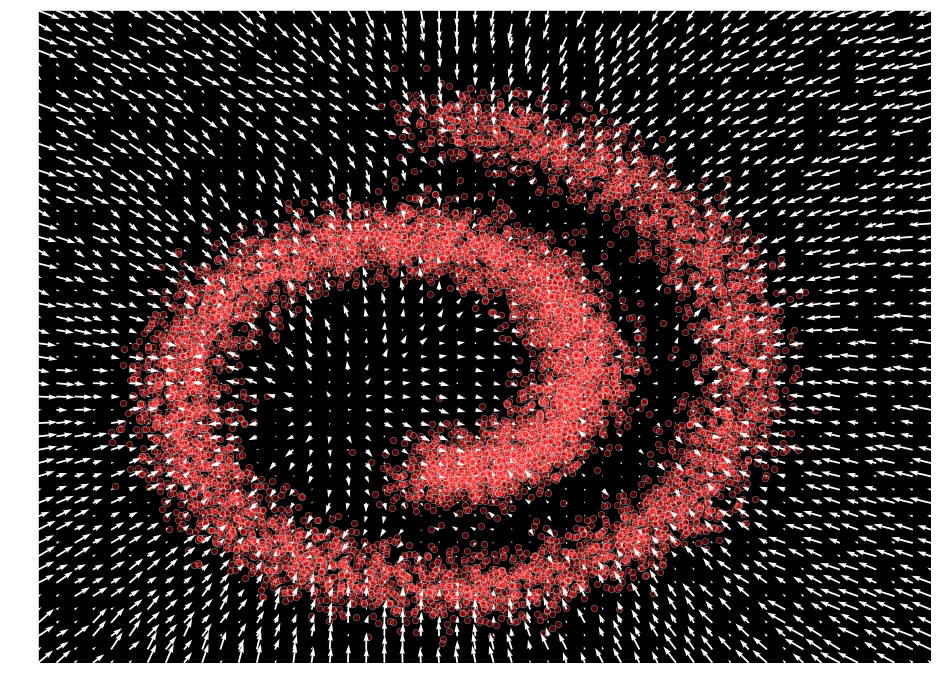

In [47]:
xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
labels = torch.randint(0, len(sigmas), (xx.shape[0],))
scores = model(torch.tensor(xx).float(), labels).detach()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
plt.xlim(-1.5, 2.0)
plt.ylim(-1.5, 2.0);

(-1.5, 2.0)

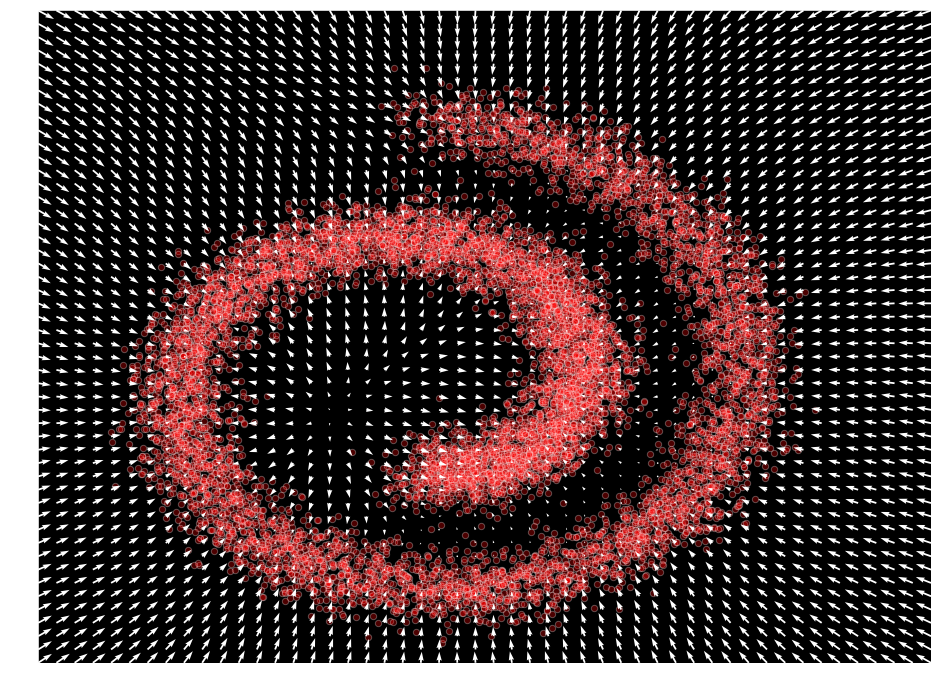

In [48]:
xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
labels = torch.ones(xx.shape[0]).long()
scores = model(torch.tensor(xx).float(), labels).detach()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
plt.xlim(-1.5, 2.0)
plt.ylim(-1.5, 2.0)

## Bibliography

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)

<a id="ref2"/>

[2] [Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.](https://arxiv.org/pdf/1503.03585)

<a id="ref3"/>

[3] [Vincent, P. (2011). A connection between score matching and denoising autoencoders. Neural computation, 23(7), 1661-1674.](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)

<a id="ref4"/>

[4] [Song, J., Meng, C., & Ermon, S. (2020). Denoising Diffusion Implicit Models. arXiv preprint arXiv:2010.02502.](https://arxiv.org/pdf/2010.02502.pdf)

<a id="ref5"/>

[5] [Chen, N., Zhang, Y., Zen, H., Weiss, R. J., Norouzi, M., & Chan, W. (2020). _WaveGrad: Estimating gradients for waveform generation_. arXiv preprint arXiv:2009.00713.](https://arxiv.org/pdf/2009.00713)

<a id="ref6"/>

[6] [Hyvärinen, A. (2005). Estimation of non-normalized statistical models by score matching. Journal of Machine Learning Research, 6(Apr), 695-709.](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf)

<a id="ref7"/>

[7] [Song, Y., Garg, S., Shi, J., & Ermon, S. (2020, August). Sliced score matching: A scalable approach to density and score estimation. In Uncertainty in Artificial Intelligence (pp. 574-584). PMLR.](https://arxiv.org/pdf/1905.07088.pdf)

<a id="ref8"/>

[8] [Song, Y., & Ermon, S. (2019). Generative modeling by estimating gradients of the data distribution. In Advances in Neural Information Processing Systems (pp. 11918-11930).](https://arxiv.org/pdf/1907.05600.pdf)

### Inspiration and sources

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/score_matching.ipynb

https://github.com/ermongroup/sliced_score_matching